# MNIST Complex Pattern (2 events)

Instead of providing labels for single MNIST digits, we train on triples of images labeled with the complex pattern of the three-digit sequence. Here we only consider 4 MNIST digits 0, 1, 2, and 3.

- If in the sequence, digit 1 appears before digit 3 (e.g., [1, 2, 3] or [1, 3, 1]), then the label for this pattern is 0.
- If in the sequence, digit 0 appears before digit 2 (e.g., [0, 3, 2] or [0, 2, 2]), then the label for this pattern is 1.
- Otherwise, the label will be 2.

In [1]:
import sys
sys.path.append('../')

from tqdm import tqdm
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

from img_data import complex_pattern

Load part of MNIST dataset: only load images for digits 0, 1, 2, and 3.

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist_train_data = torchvision.datasets.MNIST(root='./', train=True, download=True, transform=transform)
mnist_test_data = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)


n_mnist_class = 4
prim_class_names = [i for i in range(n_mnist_class)]

train_filter = mnist_train_data.targets < 0
for i in range(n_mnist_class):
    train_filter = train_filter | (mnist_train_data.targets==i)
mnist_train_data.data, mnist_train_data.targets = mnist_train_data.data[train_filter], mnist_train_data.targets[train_filter]

test_filter = mnist_test_data.targets < 0
for i in range(n_mnist_class):
    test_filter = test_filter | (mnist_test_data.targets==i)
mnist_test_data.data, mnist_test_data.targets = mnist_test_data.data[test_filter], mnist_test_data.targets[test_filter]

mnist_datasets = {
    "train": mnist_test_data,
    "test": mnist_test_data,
}

# Supervise image classifier w/ complex event labels using PYLON
In this part, we will first generate a complex event dataset according to predifined FSM rules, and then define PYLON constraints for trianing using distant (high-level) complex event label.

We define three complex event classes:
> $e_0$: Digit 1 occurs before 3.  
$e_1$: Digit 0 occurs before 2.  
$e_2$: Any event that does not satisify previous event patterns.

Corresponding FSMs are defined in `fsm.py`. To see details of the complex event dataset, check `complex_pattern` function in `image_data.py`.

## Generate complex event dataset for PYLON training


In [3]:
# Generate complex event training/test set using prmitive dataset
from fsm import Event0, Event1

fsm_list = [Event0(), Event1()]
event_class_names = ["Event 0", "Event 1", "No events"]
n_event_class = len(fsm_list) + 1

arity = 3
event_train_data = complex_pattern(n=arity, dataset="train", prim_datasets=mnist_datasets, fsm_list=fsm_list, seed=0)
event_test_data = complex_pattern(n=arity, dataset="test", prim_datasets=mnist_datasets, fsm_list=fsm_list, seed=0)

Load training and testing dataset

In [4]:
event_train_kwargs = {'batch_size': 1}
event_train_loader = DataLoader(event_train_data, **event_train_kwargs)

# Used to test correctness of predicted pattern labels
event_test_kwargs = {'batch_size': 1}
event_test_loader = DataLoader(event_test_data, **event_test_kwargs)

# Used to test individual mnist classification accuracy
mnist_test_kwargs = {'batch_size': 256}
mnist_test_loader = DataLoader(mnist_test_data, **mnist_test_kwargs)

Declare neural network model

## Define PYLON constraints for complex events
We use the previous FSMs as constraints

In [5]:
from pylon.constraint import constraint

def enforce_pattern(*logits_sequence, **kwargs):
    '''
    logits_sequence: a sequence of logits tensors returned by the primitive classifier
    kwargs['event_label']: ground truth complex event label
    kwargs['event_fsm']: a list of finite state machines for corresponding complex event class
    kwargs['n_event_class]: the number of complex event classes
    '''
 
    for fsm in kwargs['event_fsm']:
        if fsm.check(logits_sequence) == True: # (torch,torch,torch) == (int,int,int) in pylon constraints
            return fsm.label == kwargs['event_label']
    return kwargs['n_event_class'] - 1 == kwargs['event_label']

enfore_pattern_cons = constraint(enforce_pattern)

## Training and Evaluation

In [6]:
# MNIST classifier

class MNIST_Net(nn.Module):
    def __init__(self, N=10):
        super(MNIST_Net, self).__init__()
        self.n_class = N
        self.encoder = nn.Sequential(
            nn.Conv2d(1,  6, 5),
            nn.MaxPool2d(2, 2), # 6 24 24 -> 6 12 12
            nn.ReLU(True),
            nn.Conv2d(6, 16, 5), # 6 12 12 -> 16 8 8
            nn.MaxPool2d(2, 2), # 16 8 8 -> 16 4 4
            nn.ReLU(True)
        )
        self.classifier =  nn.Sequential(
            nn.Linear(16 * 4 * 4, 120),
            # nn.Linear(6 * 12 * 12, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, N)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(-1, 16 * 4 * 4)
        # x = x.view(-1, 6 * 12 * 12)
        x = self.classifier(x)
        return x

In [7]:
from utils import plot_confusion_matrix, prim_test, prim_train, PlotHelper

In [8]:
def pylon_train(model, n_epoch, optimizer, n_print=500):
    plot_loss = PlotHelper()
    for epoch in range(n_epoch):
        print("Epoch: ", epoch)
        # train
        for i, batch in enumerate(tqdm(event_train_loader)):
            model.train()
            optimizer.zero_grad()
            # print(len(x_event_train))
            img1, img2, img3, label = batch
        
            output1 = model(img1)
            output2 = model(img2)
            output3 = model(img3)
            
            pred1 = output1.argmax(dim=1, keepdim=False)
            pred2 = output2.argmax(dim=1, keepdim=False)
            pred3 = output3.argmax(dim=1, keepdim=False)
            # print("o",output1)
            
            closs = enfore_pattern_cons(output1, output2, output3, event_label=label, event_fsm=fsm_list, n_event_class=n_event_class)
            dampner = closs.detach()
            plot_loss.add(closs = dampner)

            closs.backward()
            optimizer.step()
            
            if i % n_print == 0 and i != 0:
                prim_test(model, mnist_test_loader)

    plot_loss.show()

In [9]:
def event_test(model, cm=False):
    model.eval()
    model.to('cpu')
    correct = 0
    # correct_class = [[] for _ in range(n_event_class)]
    class_correct = [0. for i in range(model.n_class)]
    class_total = [0. for i in range(model.n_class)]
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for i1, i2, i3, label in event_test_loader:

            output1 = model(i1)
            output2 = model(i2)
            output3 = model(i3)
            
            pred1 = output1.argmax(dim=1, keepdim=False)  # get the index of the max log-probability
            pred2 = output2.argmax(dim=1, keepdim=False)  
            pred3 = output3.argmax(dim=1, keepdim=False)

            pred_label = n_event_class - 1
            for e in fsm_list:
                if e.check([pred1, pred2, pred3]) is True:
                    pred_label = e.label
                    break

            correct += (pred_label == label).sum().item()
            
            
            # for i in range(n_event_class):
            #     n_correct_event[i] += (pred_label == label == i).sum().item()
            c = pred_label == label
            for i in range(len(label)):
                l = label[i]
                class_correct[l] += c[i].item()
                class_total[l] += 1
                
            y_true.extend(label.data.cpu().numpy())
            y_pred.extend(np.array([pred_label]))
            
    if cm:
        plot_confusion_matrix(y_true, y_pred, event_class_names)
        
    print('Test set: Overall Complex Event Accuracy: {}/{} ({:.0f}%)\n\
          Complex Event 0 Accuracy: {}/{} ({:.0f}%)\n\
          Complex Event 1 Accuracy: {}/{} ({:.0f}%)\n\
          Complex Event 2 Accuracy: {}/{} ({:.0f}%)\n'
          .format(correct, len(event_test_loader),
                  100. * correct / len(event_test_loader),
                  class_correct[0], class_total[0],
                  100. * class_correct[0] / (class_total[0]),
                  class_correct[1], class_total[1],
                  100. * class_correct[1] / class_total[1],
                  class_correct[2], class_total[2],
                  100. * class_correct[2] / class_total[2]))

Epoch:  0


  0%|          | 0/1385 [00:00<?, ?it/s]

/home/nesl/Documents/PYLON-CE-examples/CE-image-examples/../pylon/brute_force_solver.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.tensor(data=self.cond(*sample,**kwargs), dtype=torch.bool) for sample in samples ])
 38%|███▊      | 520/1385 [00:05<00:11, 73.46it/s] 

Accuracy of the network on the test data: 78 %
Accuracy of activity  0 : 100 %
Accuracy of activity  1 : 78 %
Accuracy of activity  2 : 51 %
Accuracy of activity  3 : 84 %


 73%|███████▎  | 1012/1385 [00:10<00:04, 77.15it/s]

Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 97 %
Accuracy of activity  1 : 99 %
Accuracy of activity  2 : 96 %
Accuracy of activity  3 : 96 %


100%|██████████| 1385/1385 [00:14<00:00, 97.56it/s] 
/home/nesl/Documents/PYLON-CE-examples/CE-image-examples/../utils.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  self.fig.show()


Accuracy of the network on the test data: 97 %
Accuracy of activity  0 : 98 %
Accuracy of activity  1 : 99 %
Accuracy of activity  2 : 98 %
Accuracy of activity  3 : 91 %


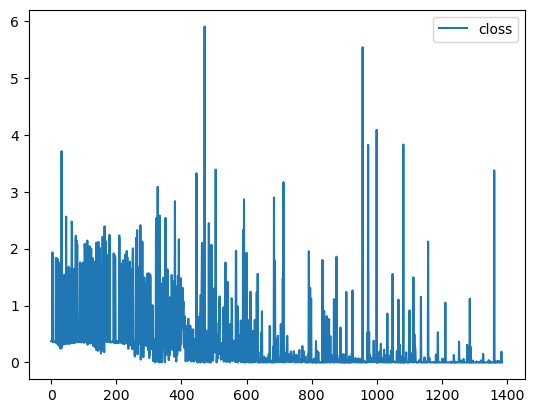

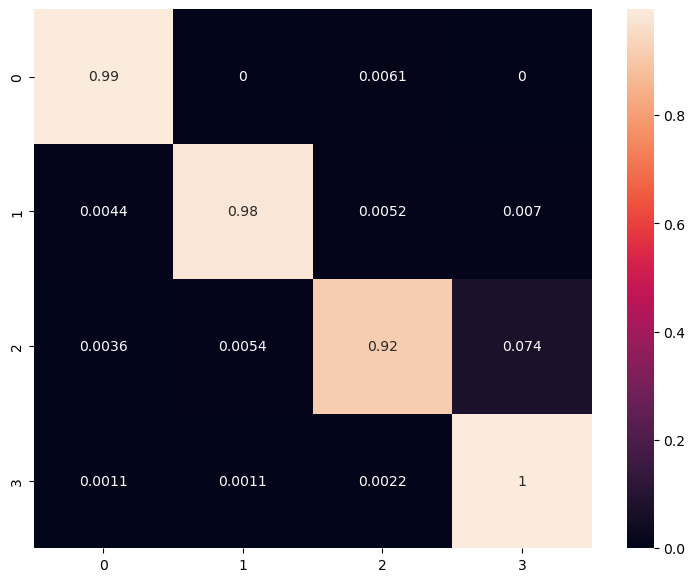

In [10]:
model = MNIST_Net(n_mnist_class)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
pylon_train(model, 1, optimizer)
y_true, y_pred, _ = prim_test(model, mnist_test_loader)
plot_confusion_matrix(y_true, y_pred, prim_class_names)

Test set: Overall Complex Event Accuracy: 1354/1385 (98%)
          Complex Event 0 Accuracy: 191.0/205.0 (93%)
          Complex Event 1 Accuracy: 188.0/191.0 (98%)
          Complex Event 2 Accuracy: 975.0/989.0 (99%)



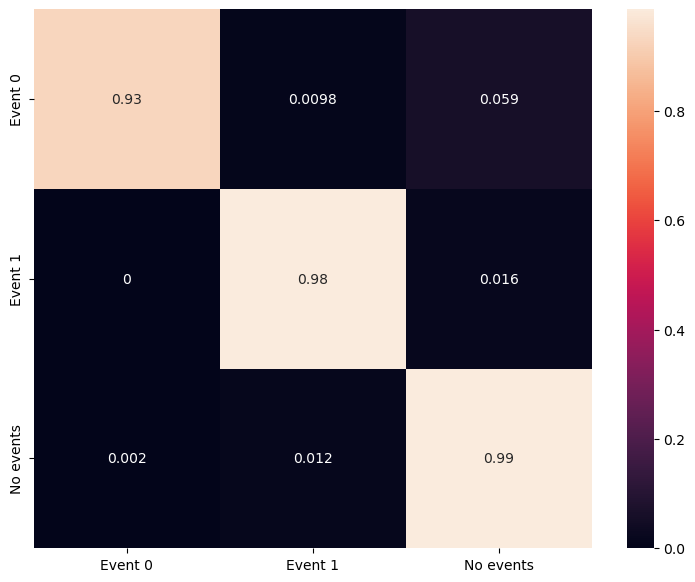

In [11]:
event_test(model, cm=True)